# Online Auction Analytics _[Kaggle competition](https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot)_

## Is the bid made by Human or by Robot?

## Background

Human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting.

In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions. Their attempt at building a model to identify these bids using behavioral data, including bid frequency over short periods of time, has proven insufficient. 

The goal of this project is to identify online auction bids that are placed by "robots", helping the site owners easily flag these users for removal from their site to prevent unfair auction activity. 

## Known issues

1. Bid frequency over short periods of time has proven insufficient
2. Bidding behavior can be learned from the time of the bids, the auction, the device, or the country

## What does this notebook do?
* **Data Wrangling**
  
  This would always be the first part of data analysis. By doing data wrangling, the data would be more clear in structure which help developers to better understand what the data really talking about.
  
  
* **Data Story**

  Exploring data and then presenting findings as a story could be really helpful for both developers and readers. In this notebook, findings were presented through graphs and text.
  
  **Below are 5 questions I am going to explore:**
   * What is the proportion of human/robot bidders?
   * What are the behavioral differences/similarities between human and robot bidders? 
   * Which merchandises do robot bidders prefer?
   * Which countries have more robots bidders? 
   * Which devices people prefer to run bid-software?


**Import necessary python packages**

In [2]:
#load all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import pycountry
import itertools

%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

**Creat functions**

Functions can make codes re-usable and make the notebook looks compact. Description of functions are available at the begining of every function.

In [191]:
#Functions
#----------------------------------#
#- Function name: categorising    -#
#- Usage: to convert string       -#
#-        features to categorical -#
#-        features and represent  -#
#-        data by their codes     -#
#- Arguments:                     -#
#-      data: dataset for analysis-#
#-    column1-3: columns to be    -#
#-               converted        -#
#----------------------------------#
def categorising(data, column1, column2, column3):
    data[column1] = data[column1].astype('category')
    data[column2] = data[column2].astype('category')
    data[column3] = data[column3].astype('category')
    cat_columns = data.select_dtypes(['category']).columns
    #represent data by their codes
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
#------------------------------------#
#- Function name: mergedata         -#
#- Usage: to merge two data sets    -#
#-        on their common columns   -#
#- Arguments:                       -#
#-      data: dataset for analysis  -#
#-    bidder: selected bidder for   -#
#-            further analysis,     -#
#-            the bidders are almost-#
#-            randomly selected     -#
#------------------------------------#
def mergedata(data, bidder):
    mer_bidder = data.merge(bidder, left_on = 'bidder_id', right_on = 'bidder_id', how = 'left')
    return mer_bidder[mer_bidder.payment_account.notnull()]
#-----------------------------------#
#- Function name: scatter_plot     -#
#- Usage: to build scatter plots   -#
#-        on bid_id and time       -#
#- Arguments:                      -#
#-    auctions: code of auctions   -#
#-      data: dataset for analysis -#
#-      ncol: number of columns for-#
#-            the subplots         -#
#-      nrow: number of rows for   -#
#-            the subplots         -#
#-----------------------------------#
def scatter_plot(auctions, data, ncol, nrow):
    #set up figure size and subplots
    fig, axs = plt.subplots(ncols = ncol, nrows = nrow, figsize = (12, 15), sharex =True, sharey=True)
    i = 0
    for auction in auctions.index:
        df = data[data['auction'] == auction]
        sns.regplot(x = 'bid_id', y = 'time', data = df, ax = axs[i], fit_reg=False)
        axs[i].set_title('auction: {}'.format(auction))
        i += 1
    fig.tight_layout()
#----------------------------------#
#- Function name: conv_bar_plot   -#
#- Usage: to convert string values-#
#-        to numericals ones and  -#
#-        build a bar plot        -#
#- Arguments:                     -#
#-      data: dataset for analysis-#
#-    column: the column used for -#
#-            build bar plot      -#
#----------------------------------#
def conv_bar_plot(data, column):
    #change string values to numerical ones.
    mer_cates = data[column].unique()
    num_cates = range(len(mer_cates))
    train_bid.replace(mer_cates, num_cates, inplace = True)
    _ = sns.barplot(data=data, x=column, y='outcome')
    _ = plt.ylabel('percentage labeled as robots')
    _ = plt.title('which {} do robot bidders prefer?'.format(column))
#--------------------------------------#
#- Function name: bids_per_auction    -#
#- Usage: to build histogram of       -#
#-        number of bids that a       -#
#-        bidder made per auction     -#
#- Arguments:                         -#
#-      data: dataset for analysis    -#
#-  columns1: contain two columns     -#
#-            one used for groupby;   -#
#-            the other as denominator-#
#-  columns2: contain two columns     -#
#-            one used for groupby;   -#
#-            the other as numerator  -#
#--------------------------------------#
def bids_per_auction(data, columns1=[], columns2=[], mean = False):
    bots_num_auction = pd.DataFrame(data[data['outcome'] == 1][columns1]\
                       .groupby(columns1[0])[columns1[1]].nunique())
    bots_num_bids = data[data['outcome'] == 1][columns2].groupby(columns2[0]).count()
    human_num_auction = pd.DataFrame(data[data['outcome'] == 0][columns1]\
                       .groupby(columns1[0])[columns1[1]].nunique())
    human_num_bids = data[data['outcome'] == 0][columns2].groupby(columns2[0]).count()
    if mean == False:
        bots_avg = pd.DataFrame(bots_num_bids[columns2[1]]/bots_num_auction[columns1[1]])
        bots_avg = bots_avg.rename(columns = {0:'average bids per auction'})
        fig, axses = plt.subplots(ncols = 2, nrows = 1, figsize = (7, 4), sharex =False, sharey=False)
        _ = sns.distplot(bots_avg['average bids per auction'],
                     hist_kws=dict(cumulative=True),
                     kde_kws=dict(cumulative=True), 
                     ax = axses[0])
        _ = axses[0].set_ylabel('Probability')
        _ = axses[0].set_xlabel('number of bids')
        _ = axses[0].set_title('ROBOT')
        #human_num_auction = pd.DataFrame(data[data['outcome'] == 0][columns1]\
        #               .groupby(columns1[0])[columns1[1]].nunique())
        #human_num_bids = data[data['outcome'] == 0][columns2].groupby(columns2[0]).count()
        human_avg = pd.DataFrame(human_num_bids[columns2[1]]/human_num_auction[columns1[1]])
        human_avg = human_avg.rename(columns = {0:'average bids per auction'})
        _ = sns.distplot(human_avg['average bids per auction'],
                     hist_kws=dict(cumulative=True),
                     kde_kws=dict(cumulative=True), 
                     ax = axses[1])
        _ = axses[1].set_ylabel('Probability')
        _ = axses[1].set_xlabel('number of bids')
        _ = axses[1].set_title('HUMAN')
        plt.tight_layout()
    else:
        bots_data = pd.DataFrame(bots_num_bids[columns2[1]]/bots_num_auction[columns1[1]])
        bots_avg = bots_data.mean()
        #bots_avg = bots_avg.rename(columns = {0:'average bids per auction'})
        human_data = pd.DataFrame(human_num_bids[columns2[1]]/human_num_auction[columns1[1]])
        human_avg = human_data.mean()
        #human_avg = human_avg.rename(columns = {0:'average bids per auction'})
        #hu_bot = pd.DataFrame(bots_avg[0], human_avg[0])
        lis = [bots_avg, human_avg]
        df = pd.DataFrame(lis)
        return df, human_data, bots_data
#-----------------------------------#
#- Function name: dist_most        -#
#- Usage: to visualize proportion  -#
#-        of bots bidders for      -#
#-        categorical variables    -#
#- Arguments:                      -#
#-      data: the dataset used     -#
#-            used for analysis    -#
#-      column: the variable to be -#
#-              visualized         -#
#-----------------------------------#
def dist_most(data, column):
    grouped_cols = pd.DataFrame(data.groupby('outcome')[column].value_counts()).\
                             rename(columns={column:'number_of_bidders'}).reset_index()
    grouped_cols_bots = grouped_cols[grouped_cols.outcome == 1]
    grouped_cols_human = grouped_cols[grouped_cols.outcome == 0]
    merged = grouped_cols_human.merge(grouped_cols_bots, left_on = column, right_on = column, how = 'left')
    merged['proportion'] = merged.number_of_bidders_y/(merged.number_of_bidders_y + merged.number_of_bidders_x)
    merged_grouped = merged.sort('proportion').dropna()
    merged_grouped = merged_grouped[(merged_grouped['number_of_bidders_x']\
                                        +merged_grouped['number_of_bidders_y'])>= 100]
    merged_grouped.rename(columns={'number_of_bidders_x': 'num_human_bidders', 
                                   'number_of_bidders_y':'num_bots_bidders'}, inplace = True)
    display(merged_grouped.tail(10))
    if column == 'country':
        _ = sns.distplot(merged_grouped.proportion, bins = 20, kde=False, rug=False, 
                     hist_kws=dict(cumulative=True),
                     kde_kws=dict(cumulative=True))
        _ = plt.xlabel("proportion of robot bidders")
    
        _ = plt.ylabel('number of countries')
        
        _ = plt.title('proportion of robot bidders by countries')
    fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5), sharex =False, sharey=False)
    plot_data = merged_grouped[[column, 'proportion']].set_index(column).tail(10)
    _ = plot_data.plot(kind='bar', ax = axes[0])
    _ = axes[0].set_ylabel('proportion of robot bidders')
    _ = axes[0].set_title('Top 10 {} with largest percent of robot bidders'.format(column))
    _ = axes[0].legend().set_visible(False)
    plot_data = merged_grouped[[column, 'proportion']].set_index(column).head(10)
    _ = plot_data.plot(kind='bar', ax = axes[1])
    _ = axes[1].set_ylabel('proportion of robot bidders')
    _ = axes[1].set_title('Top 10 {} with smallest percent of robot bidders'.format(column))
    _ = axes[1].legend().set_visible(False)
    plt.tight_layout()
    
    return merged_grouped
#-----------------------------------#
#- Function name: dist_most        -#
#- Usage: to visualize proportion  -#
#-        of bots bidders for      -#
#-        categorical variables    -#
#- Arguments:                      -#
#-      data: the dataset used     -#
#-            used for analysis    -#
#-      column: the variable to be -#
#-              visualized         -#
#-----------------------------------#
def draw_map(data):
    countries = pd.DataFrame(data.country.apply(lambda x: x.upper()))
    country_dict = {}
    for country_code in countries.country:
        for country in pycountry.countries:
            if country_code == country.alpha_2:
                country_dict[country_code] = country.name
    
    df = pd.DataFrame.from_dict(country_dict, orient='index').reset_index().\
                  rename(columns={'index':'country_code', 0:'country_name'})
    
    pro_country = grouped[['proportion', 'country']]
    pro_country.country = pro_country.country.apply(lambda x: x.upper())
    code_name_pro = pro_country.merge(df, left_on='country', right_on='country_code', how = 'left').drop('country', axis=1)
    
    
    
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)
    lst = list(code_name_pro.proportion)

    minima = min(lst)
    maxima = max(lst)

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.CMRmap_r)
    rgb_lst = []
    for v in lst:
        rgb_lst.append(list(mapper.to_rgba(v)))

    plt.figure(figsize=(12,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for country in shpreader.Reader(countries_shp).records():
        for i in range(len(code_name_pro.country_name)):
            if (country.attributes['name_long']) == code_name_pro.country_name[i]:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor=rgb_lst[i],
                                  label=country.attributes['name_long'])
    plt.title("Robot bidders' distribution")
    mapper.set_array(lst)
    plt.colorbar(mapper, fraction=0.023, pad=0.04)

#-----------------------------------#
#- Function name: comp_paras       -#
#- Usage: to compute parameters    -#
#-        for hypothesis test      -#
#- Arguments:                      -#
#-      data: the dataset used     -#
#-            used for analysis    -#
#-   merchan: = None               -#
#-            test all dataset     -#
#-            != None              -#
#-            test data of exact   -#
#-            merchandise          -#
#-----------------------------------#    
def comp_paras(human, robot):
    
    mean_b = np.mean(robot)
    mean_h = np.mean(human)
    #mean = mean_h - mean_b
    #mu = 0
    std_b = np.std(robot)
    std_h = np.std(human)
    sigma_b = std_b[0]/np.sqrt(len(robot))
    sigma_h = std_h[0]/np.sqrt(len(human))
    sigma = np.sqrt(sigma_b**2 + sigma_h**2)
    return len(robot), len(human), mean_b, mean_h, std_b, std_h, sigma

# Data Wrangling
Introduction to dataset:
This project contains 3 datasets:
* bids.csv: information of all bids
* train.csv: information of bidders which are already labeled, used to train the model
* test.csv: information of bidders which are not labeled, used to test the model

In order to explore data before building models, it is better to know which bids are made by human/robots. To do this, we can merge train/test with bids.csv on bidder_id. After merging datasets, we should have bids, bidders information together with its label(human or robots). Also we will have two separate merged datasets: train_bid and test_bid, which will be used for predictive modeling. 

In [5]:
#load and view data
data = pd.read_csv('Data/bids.csv')
data.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [6]:
#Merge training data with bids data, because only training data has 'outcome' column, which will be used as labels
bidder_train = pd.read_csv('Data/train.csv')
train_bid = mergedata(data, bidder_train)
train_bid.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,payment_account,address,outcome
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,a3d2de7675556553a5f08e4c88d2c228ucoac,42a3b61a1fe69d66ad60f3e347aa09b1erfe2,0.0
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3,2c198811bf76f74512e24f5a537e21f9o3kyh,4e408da3d4dc783220f7d7c6a2f6bb62fxl68,0.0
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
10,10,a58ace8b671a7531c88814bc86b2a34cf0crb,z6j8b,sporting goods,phone10,9759243210526315,ng,209.80.85.101,adgjz71s3p2oiau,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
13,13,7e34a26c4c339e875997f4b9239d2b5fscng4,nbx39,mobile,phone13,9759243263157894,in,143.183.225.33,e5i17pk9wygxewv,d1154cf7f47d7be0579cf24f6df1edcaagi99,fe7698870c64030109477f0d692741bfb3jn2,0.0


# Data Story

## Proportion of human bidders and robot bidders

To see how difficult the problem is, looking at the proportion of two types of bidders could be a good idea.

Robot bidders: 5.2%
Human bidders: 94.8%


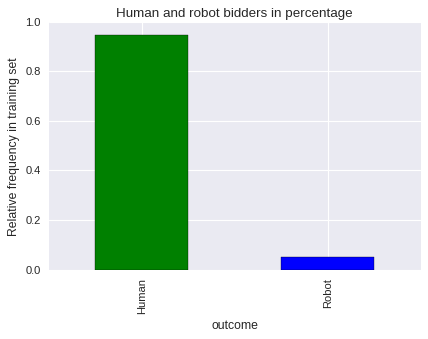

In [7]:
pro_plot = (train_bid.groupby(['outcome', 'bidder_id']).count().reset_index()\
                                           .drop('bidder_id', axis=1).groupby('outcome').count().bid_id\
                                           /train_bid.bidder_id.nunique())
_ = pro_plot.plot(kind='bar', color = ['g', 'b'])
_ = plt.xticks(range(2), ['Human', 'Robot'])
_ = plt.ylabel('Relative frequency in training set')
_ = plt.title('Human and robot bidders in percentage')

print("Robot bidders: {0:.1f}%".format(pro_plot[1] * 100))
print("Human bidders: {0:.1f}%".format(pro_plot[0] * 100))

Human bidders are way more than robot bidders. Since only 5.2% bidders are classified as robots, it seems robot bidders will not cause big problem for online bidding. However, it is too early to make any conclusion.

## Behaviors of human and robot bidders

First, let me ask some questions: 
* How many auctions do robot bidders participate in? How about human bidders?
* How many bids are made by robot bidders? How about human bidders?

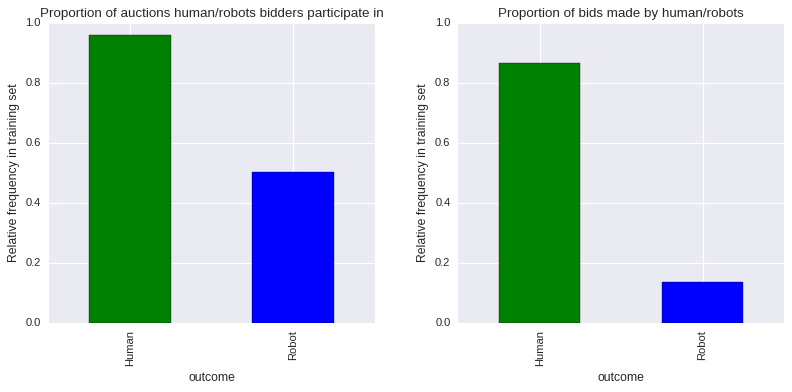

In [12]:
auc_plot = (train_bid.groupby(['outcome','auction']).count().bid_id)\
                                         .reset_index().drop('auction', axis = 1).groupby('outcome').count()\
                                         .bid_id/train_bid.auction.nunique()
fig, axes = plt.subplots(ncols=2, nrows=1, figsize= (10,5))
_ = auc_plot.plot(kind='bar', color=['g','b'], ax=axes[0])
_ = axes[0].set_xticklabels(['Human', 'Robot'])
_ = axes[0].set_ylabel('Relative frequency in training set')
_ = axes[0].set_title('Proportion of auctions human/robots bidders participate in')

_ = (train_bid.groupby('outcome').count().bid_id/len(train_bid)).plot(kind='bar', color=['g','b'], ax=axes[1])
_ = axes[1].set_xticklabels(['Human', 'Robot'])
_ = axes[1].set_ylim([0,1])
_ = axes[1].set_ylabel('Relative frequency in training set')
_ = axes[1].set_title('Proportion of bids made by human/robots')
plt.tight_layout()

* More than 50% of auctions have robot bidders, while 96% have human bidders;
* About 4% auctions only have robot bidders;
* According to previous findings, only 5.2% robot bidders participate in 50% auctions.
* Although robot bidders participate in more than 50% auctions, they do not make so many bids as expected.

As it is mentioned in the Kaggle competition page, number of bids is not efficient for recognizing whether a bidder is human or robot. We do find that robot bidders do not make much more bids than human bidders. One of the reason behind is: Robot bidders aim to win bids rather than make more bids. Therefore, they are more likely to make bids at the last few seconds of auctions. 

From above findings, the variable "time" may be helpful for exploring behaviors of robot bidders.

## What are the behavioral differences in time between human & robot bidders?

**Robot bidders: **

In [9]:
#select only robot bidders
bots_data = train_bid[(train_bid.merchandise == 'mobile') & (train_bid.outcome == 1)]
eg_bots_bidder = bots_data[bots_data.bidder_id == 'fae553f133602fba6e9e6051dfb27fefkruax']
eg_bots_bids = eg_bots_bidder.groupby('auction').count().sort('bid_id').tail(6)

						  merchandise: mobile
				    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3


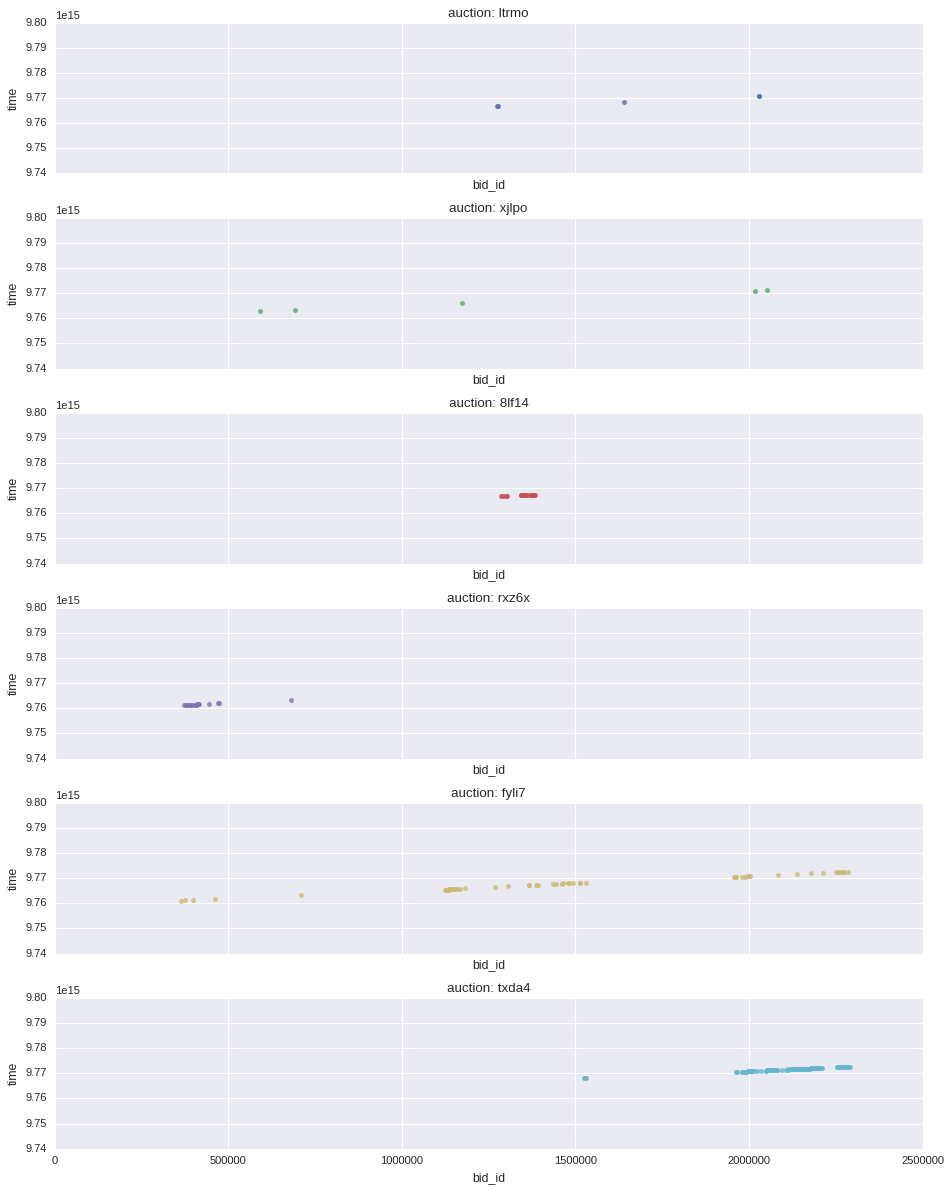

In [10]:
#plot all bids the bidder has made along with time the bids made
scatter_plot(eg_bots_bids, eg_bots_bidder, 1, 6)
print("\t\t\t\t\t\t  merchandise: mobile\n\t\t\t\t    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3")

#### Human bidders:

In [11]:
#select only human bidders
human_data = train_bid[(train_bid.merchandise == 'mobile') & (train_bid.outcome == 0)]
eg_human_bidder = human_data[human_data.bidder_id == 'ffc4e2dd2cc08249f299cab46ecbfacfobmr3']
eg_human_bids = eg_human_bidder.groupby('auction').count().sort('bid_id').tail(6)

						  merchandise: mobile
				    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3


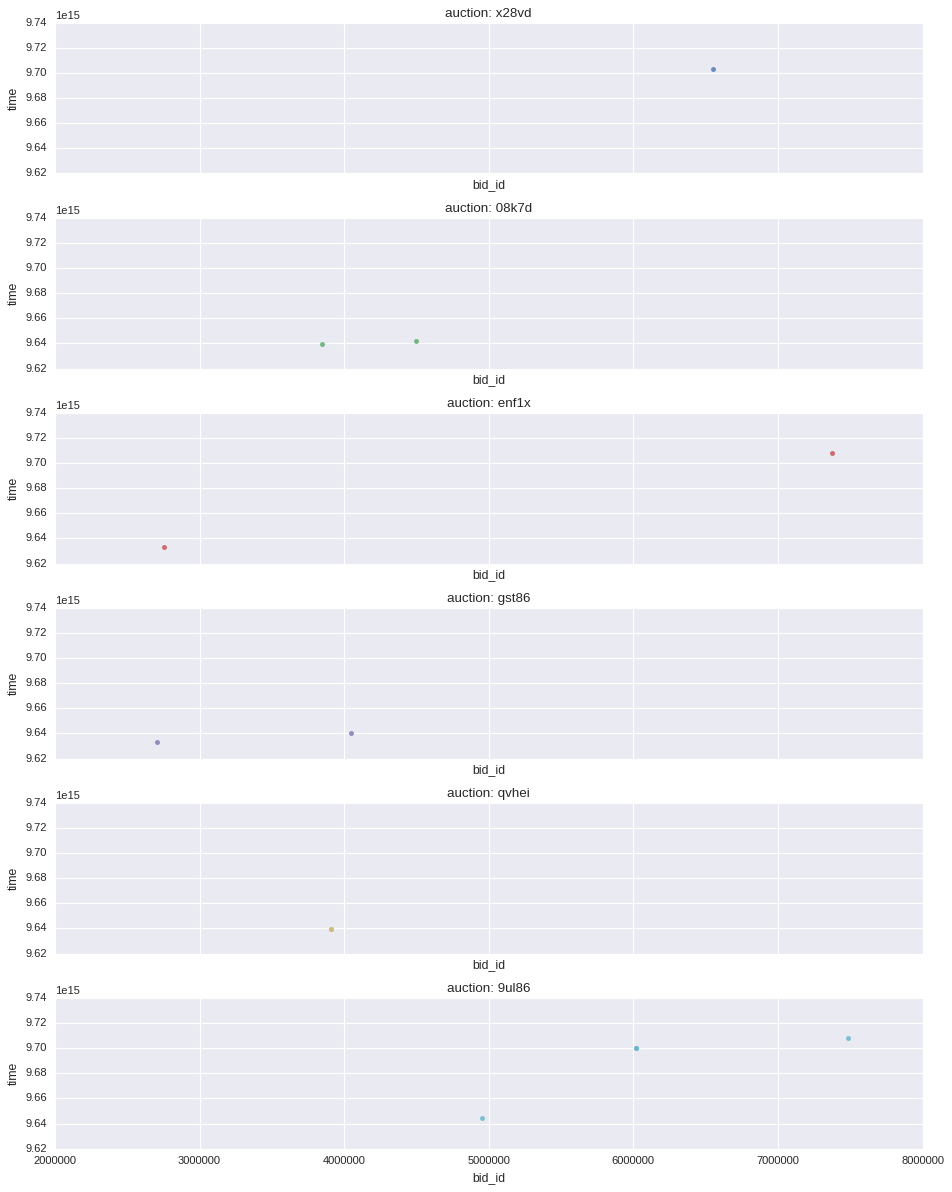

In [12]:
#plot all bids the bidder has made along with time the bids made
scatter_plot(eg_human_bids, eg_human_bidder, 1, 6)
print("\t\t\t\t\t\t  merchandise: mobile\n\t\t\t\t    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3")

* The robot bidder usually make series bids in a short period of time.
* The robot bidder only make bids in a fixed time interval(which is 9.6--9.8).
* For the human bidders, the distribution of bids he made seems more random and cannot find a specific pattern among all the auctions he participated in.

Since the above graphs are from only two bidders, it's too early to make any conclusions, but it can still provide some valuable insights before moving on.

## Which merchandise do robot bidders prefer?

In [13]:
human_plot = train_bid[train_bid.outcome == 0].groupby(['merchandise', 'bidder_id', 'auction']).count().reset_index()\
                                                          .drop(['bidder_id', 'auction'], axis = 1)\
                                                          .groupby('merchandise').count().bid_id
bot_plot = train_bid[train_bid.outcome == 1].groupby(['merchandise', 'bidder_id', 'auction']).count().reset_index()\
                                                          .drop(['bidder_id', 'auction'], axis = 1)\
                                                          .groupby('merchandise').count().bid_id

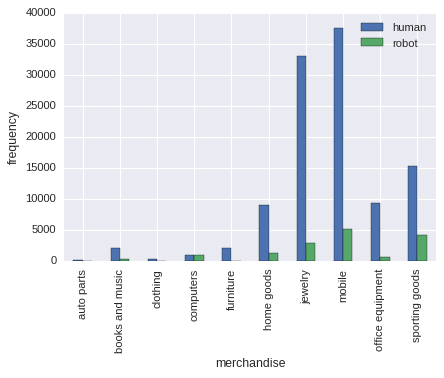

In [14]:
merged_plots = human_plot.reset_index()\
              .merge(bot_plot.reset_index(), left_on='merchandise', right_on='merchandise', how = 'left').fillna(0)
merged_plots.plot(kind='bar')
_ = plt.legend(('human', 'robot'))
_ = plt.xticks(range(10), merged_plots.merchandise, rotation = 90)
_ = plt.xlabel('merchandise')
_ = plt.ylabel('frequency')

The top 3 merchandises robot bidders would like to bid are: sporting goods, mobile, and jewelry;

The top 3 merchandises robot bidders are not likely to bid are: auto parts, clothing and furniture.

### How many bids does ROBOT/HUMAN bidders made per auction? 

#### Merchandise: mobile, sporting goods, jewelry

mobile (CDF):


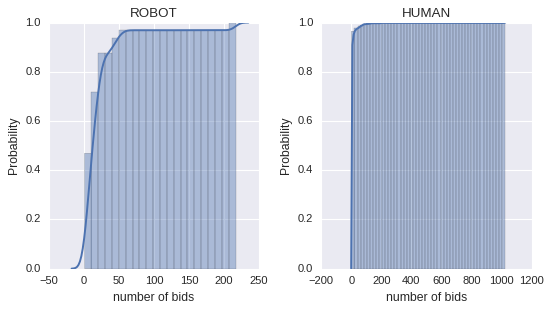

sporting goods (CDF):


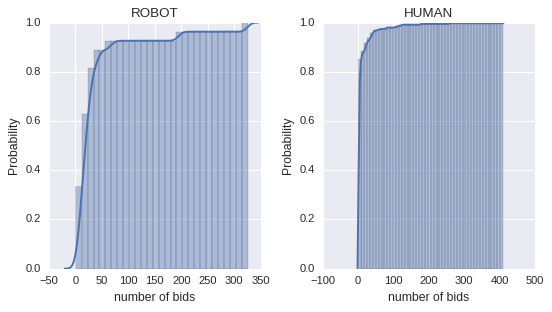

jewelry (CDF):


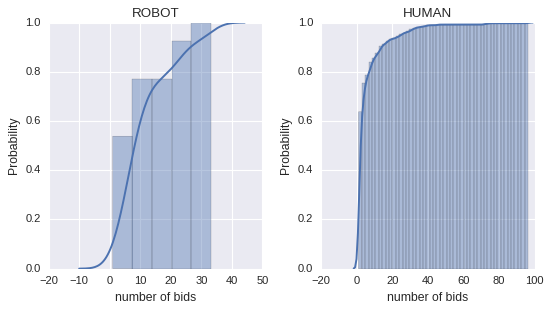

In [107]:
print("mobile (CDF):")
bids_per_auction(train_bid[train_bid.merchandise=='mobile'], \
                 columns1=['bidder_id', 'auction'], columns2=['bidder_id', 'bid_id'])
plt.show()
print("sporting goods (CDF):")
bids_per_auction(train_bid[train_bid.merchandise=='sporting goods'], \
                 columns1=['bidder_id', 'auction'], columns2=['bidder_id', 'bid_id'])
plt.show()
print("jewelry (CDF):")
bids_per_auction(train_bid[train_bid.merchandise=='jewelry'], \
                 columns1=['bidder_id', 'auction'], columns2=['bidder_id', 'bid_id'])

**average number of bids: number of bids a bidder made per auction**

The plots show cumulative distribution function (CDF) for merchandises mobile, sporting goods and jewelry. CDF plots can show the range of number of bids the bidders made. This will be helpful to understand if there's a difference in number of bids between human and robot bidders.

* Most robot bidders make more bids than human bidders, but most bidders in both groups make less than 50 bids (which means the difference between two groups would not be significant).
* Comparing to human bidders, number of bids robots made is relatively fixed -- they do not make too many bids.

Is there really a difference in mean of number of bids per auction between human and robot bidders? If there is a difference, does it make sense?

To answer the two questions, hypothesis test would be a good idea.

**However, before we start, let's build 3 more graphs:**

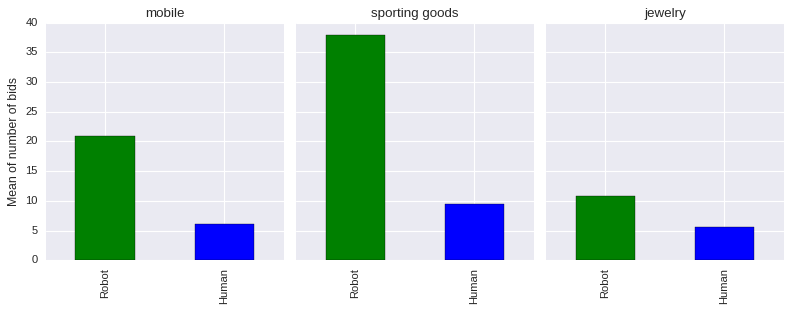

In [135]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, sharey = True, figsize = (10,4))
df_m, hu_data_m, bot_data_m = bids_per_auction(train_bid[train_bid.merchandise=='mobile'], \
                 columns1=['bidder_id', 'auction'], columns2=['bidder_id', 'bid_id'], mean = True)
_ = df_m.plot(kind = 'bar',colors=['g', 'b'], ax = axes[0])
_ = axes[0].set_title('mobile')
_ = axes[0].set_ylabel('Mean of number of bids')
_ = axes[0].set_xticklabels(['Robot', 'Human'])
_ = axes[0].legend().set_visible(False)

df_sg, hu_data_sg, bot_data_sg = bids_per_auction(train_bid[train_bid.merchandise=='sporting goods'], \
                 columns1=['bidder_id', 'auction'], columns2=['bidder_id', 'bid_id'], mean = True)
_ = df_sg.plot(kind = 'bar',colors=['g','b'], ax = axes[1])
_ = axes[1].set_title('sporting goods')
_ = axes[1].set_ylabel('Mean of number of bids')
_ = axes[1].set_xticklabels(['Robot', 'Human'])
_ = axes[1].legend().set_visible(False)

df_jy, hu_data_jy, bot_data_jy = bids_per_auction(train_bid[train_bid.merchandise=='jewelry'], \
                 columns1=['bidder_id', 'auction'], columns2=['bidder_id', 'bid_id'], mean = True)
_ = df_jy.plot(kind = 'bar',colors=['g','b'], ax = axes[2])
_ = axes[2].set_title('jewelry')
_ = axes[2].set_ylabel('Mean of number of bids')
_ = axes[2].set_xticklabels(['Robot', 'Human'])
_ = axes[2].legend().set_visible(False)

plt.tight_layout()

** Mean of number of bids: the average number of bids a bidder made per auction**

* For sporting godds, the difference in mean of number of bids per auction is the most significant
* For jewelry, the difference seems not significant.

** To test if the difference do make sence, let's do hypothesis test for each merchandise:**

### Hypothesis test --- merchandises

$H_0: \mu_b - \mu_h = 0$

$H_1: \mu_b - \mu_h \neq 0$

This time, I will make hypothesis test on top 3 merchandises that robot bidders prefer.

#### Merchandise: mobile

In [162]:
n1, n2, mean_b, mean_h, std_b, std_h, sigma = comp_paras(hu_data_m, bot_data_m)

In [163]:
mean = mean_b - mean_h
mu = 0
z = (mean - mu)/sigma

print("z-statistic: z = {0:.2f}".format(z[0]))

z-statistic: z = 2.19


$z = 2.19$ indicates significance level $\alpha = 0.9857$

Thus we can reject $H_0$ and we are 98.57% confident robot bidders make more bidders than human bidders (for merchandise mobile).

But I will ask the same question: does the difference make sense?

In [164]:
Sp = np.sqrt((std_b**2*(len(bot_data_m)-1)+std_h**2*(len(hu_data_m)-1))/(len(bot_data_m)+len(hu_data_m)-2))
d = (mean_b - mean_h)/Sp
print("Effect size: d = {0:.2f}".format(d[0]))

Effect size: d = 0.37


$d = 0.37$ indicates the difference in mean of bids between human and robot bidders do make sense (for mobile).
**But it does not have a significant effect.**

#### Merchandise: sporting goods

In [165]:
n1, n2, mean_b, mean_h, std_b, std_h, sigma = comp_paras(hu_data_sg, bot_data_sg)

In [166]:
mean = mean_b - mean_h
mu = 0
z = (mean - mu)/sigma
print("z-statistic: z = {0:.2f}".format(z[0]))

z-statistic: z = 2.21


$z = 2.21$ indicates a significance level $\alpha = 0.9861$

Thus we can reject $H_0$ and we are 98.57% confident robot bidders make more bidders than human bidders (for merchandise sporting goods).

And also, I will ask the same question: does the difference make sense?

In [167]:
Sp = np.sqrt((std_b**2*(len(bot_data_sg)-1)+std_h**2*(len(hu_data_sg)-1))/(len(bot_data_sg)+len(hu_data_sg)-2))
d = (mean_b - mean_h)/Sp
print("Effect size: d = {0:.2f}".format(d[0]))

Effect size: d = 0.81


$d = 0.81$ indicates the difference in mean of bids between human and robot bidders do make sense (for mobile). **And it has a very significant effect**

#### Merchandise: jewelry

In [168]:
n1, n2, mean_b, mean_h, std_b, std_h, sigma = comp_paras(hu_data_jy, bot_data_jy)

In [169]:
mean = mean_b - mean_h
mu = 0
z = (mean - mu)/sigma
print("z-statistic: z = {0:.2f}".format(z[0]))

z-statistic: z = 2.04


$z = 2.04$ indicates a significance level $\alpha = 0.9793$

Thus we can reject $H_0$ and we are 97.93% confident robot bidders make more bidders than human bidders (for merchandise jewelry).

Let me ask the same question one more time: does the difference make sense?

In [170]:
Sp = np.sqrt((std_b**2*(len(bot_data_jy)-1)+std_h**2*(len(hu_data_jy)-1))/(len(bot_data_jy)+len(hu_data_jy)-2))
d = (mean_b - mean_h)/Sp
print("Effect size: d = {0:.2f}".format(d[0]))

Effect size: d = 0.53


$d = 0.53$ indicates the difference in mean of bids between human and robot bidders do make sense (for mobile). **And it has a relatively significant effect**

### Conclusion for hypothesis test

It's sort of surprising that difference in mean of number of bids for jewelry has larger effect size than that for mobile. 

When making bids, behavioral difference could be very different for different merchandises. Therefore, when doing further analysis(e.g. classification), we should consider behavioral difference in each merchandises between human and robot bidders separately.

### Number of human/bots bidders for different countries

	Top 10 countries that has highest percentage of bots bidders


,outcome_x,country,num_human_bidders,outcome_y,num_bots_bidders,proportion
9,0.0,us,73380,1.0,66663.0,0.476018
99,0.0,tw,1329,1.0,1285.0,0.491584
43,0.0,au,7756,1.0,8634.0,0.526785
42,0.0,ca,7804,1.0,9205.0,0.541184
76,0.0,at,2445,1.0,3407.0,0.582194
35,0.0,de,10436,1.0,18530.0,0.639716
161,0.0,mn,33,1.0,134.0,0.802395
116,0.0,kr,634,1.0,6340.0,0.909091
125,0.0,jp,498,1.0,7921.0,0.940848
182,0.0,mo,3,1.0,140.0,0.979021


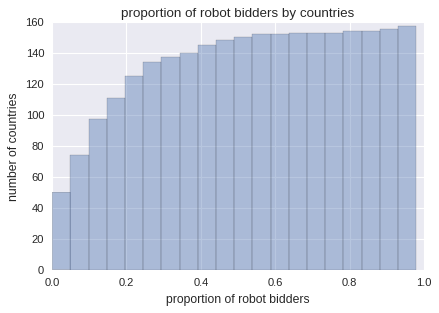

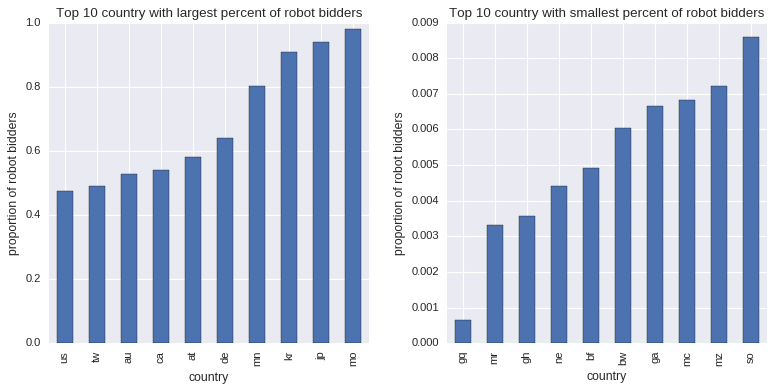

In [192]:
print('\tTop 10 countries that has highest percentage of bots bidders')
grouped = dist_most(train_bid, 'country')

* Most countires (> 110 countires, 69.18% ) have less than 20% robot bidders 
* 19 countries (11.95%) have more than 40% robot bidders
* Korea, Japan and Macau have the highest percentage of robot bidders (more than 90%), especially Macau (more than 99%).

### A map may be helpful to see the results:

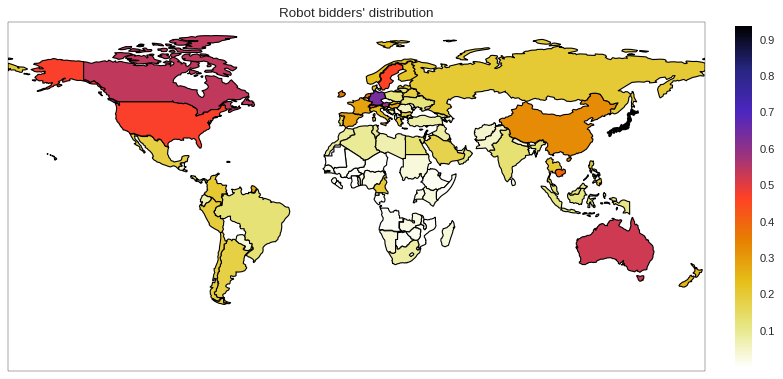

In [63]:
draw_map(grouped)

#### Note: Countries with white color may indicate they have very low percentage of bots bidders, but it also could be lack of data for certain countries (We only have 130 countries' data while there are 195 countries around the world)

Before we move on, one thing I want to let you know that I have dropped countries who has less than 100 bid records. 
Because of their small sample size, it is more likely that records of these countries are happen by chance. For example, many countries have only one record and it happen to be recognized as robot bidder. Since we are considering percentage of robot bidders, these countries will have 100% robot bidders. Therefore, I dropped countries with relatively less bid records (< 100).

From above table and plots, most countries do not have too many robot bidders(less than 10%). While other countries have significantly more amount of robot bidders. It is also surprising that U.S., Australia, Canada, Germany, Taiwan, Korea, Japan, Sweden, Austria, Israel have really large percent of robot bidders, expecially Japan and korea(more than 90% robot bidders). Since they are all deveploped regions, people in these countries may be more experienced in programming/software developing, which could result in large number of robot bidders. To prove this view, let's look at the third plot -- 10 countries with smallest percentage of robot bidders, are undeveloped and small countries, like Equatorial Guinea, Mauritania, Niger, etc. Therefore, 'country' could be a good estimator for classifying bidders' types.

### Number of human/bots bidders for different devices

	Top 10 devices that has highest percentage of bots bidders


,outcome_x,device,num_human_bidders,outcome_y,num_bots_bidders,proportion
677,0.0,phone466,209,1.0,2334.0,0.917814
1329,0.0,phone491,49,1.0,560.0,0.919540
968,0.0,phone322,99,1.0,1189.0,0.923137
1041,0.0,phone488,83,1.0,997.0,0.923148
1096,0.0,phone902,73,1.0,1058.0,0.935455
1378,0.0,phone398,44,1.0,681.0,0.939310
1390,0.0,phone559,43,1.0,712.0,0.943046
1046,0.0,phone796,82,1.0,1516.0,0.948686
1627,0.0,phone2287,29,1.0,933.0,0.969854
3096,0.0,phone883,5,1.0,549.0,0.990975


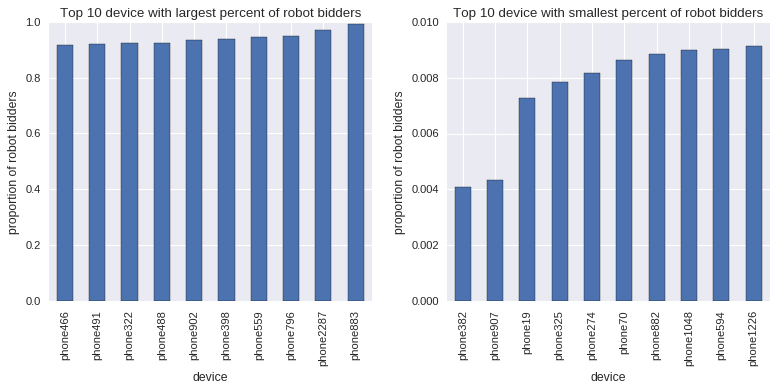

In [187]:
print('\tTop 10 devices that has highest percentage of bots bidders')
_ = dist_most(train_bid, 'device')

People prefer to use certain models to run their bid program. Since the exact phone models are not available in this dataset, we are not able to explore more based on their brands and models. However, the result shows model of phones do have realationship with bidders' type.

Because of lack of models' information in this project, it is not possible to make further analysis at this time. If I google "auction sniping tools for ios/Android", these softwares do not require latest version of oprating systems, which   indicates that people do not need to use the latest model of phones to run their program. 

**In this project, it is clear model of devices can be used to classify if the bidder is robot. (Because there is a difference in choosing devices between human and robot)**

## Further findings

If you google "bidder robot" (actually they have another name "Auction Sniper"), the result would be astonishing. Although in this project auction snipers will be removing from their site to prevent unfair auction activity, the google results show many companies are now selling auction sniper online to help people make bids. If you look at those software, you can even set up your own strategy to avoid classifying as robot bidders. For example, you can tell the robot which item and auction to bid on, who your friends are, what price range you can accept. You can standardized their behavior to make it like human bidders. I also have experience making bids online (e.g. eBay). I know that kind of feeling when your bids are 'stolen' by others at the last 5 seconds. It is really unfair for humans to make bids against robots. 

Some auction sites (such as iGavel, the New Zealand auction site TradeMe, and the real estate auction site Bid on the City) automatically extend the bid deadline by a few minutes if a bid is placed in the last moments of the auction, to give other buyers time to react.